### SketchGraphs demo

In this notebook, we'll first go through various ways of representing and inspecting sketches in SketchGraphs. We'll then take a look at using Onshape's API in order to solve sketch constraints.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
from copy import deepcopy
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
# cd to top-level directory
if os.path.isdir('../sketchgraphs/'): 
    os.chdir('../')

import sketchgraphs.data as datalib
from sketchgraphs.data import flat_array
import sketchgraphs.onshape.call as onshape_call

Let's first load in some sketch construction sequences. In this example, we'll be using the [validation set](https://sketchgraphs.cs.princeton.edu/sequence/sg_t16_validation.npy) (see [documentation](https://princetonlips.github.io/SketchGraphs/data) for details). This notebook assumes the data file is already downloaded and located in a directory `sequence_data`.

In [2]:
seq_data = flat_array.load_dictionary_flat('sequence_data/sg_t16_validation.npy')
seq_data['sequences']

FlatArray(len=315228, mem=186.9 MB)

This file has 315,228 sequences. Let's take a look at some of the operations in one of the sequences.

In [3]:
seq = seq_data['sequences'][1327]
print(*seq[:20], sep='\n')

NodeOp(label=<EntityType.External: 7>, parameters={})
NodeOp(label=<EntityType.Line: 1>, parameters={'isConstruction': False, 'dirX': 1.0, 'dirY': 0.0, 'pntX': -0.0011842120438814163, 'pntY': 0.0, 'startParam': -0.01264495235582774, 'endParam': 0.02118421204388142})
EdgeOp(label=<ConstraintType.Horizontal: 4>, references=(1,), parameters={})
NodeOp(label=<SubnodeType.SN_Start: 101>, parameters={})
EdgeOp(label=<ConstraintType.Subnode: 101>, references=(2, 1), parameters={})
EdgeOp(label=<ConstraintType.Horizontal: 4>, references=(2, 0), parameters={})
NodeOp(label=<SubnodeType.SN_End: 102>, parameters={})
EdgeOp(label=<ConstraintType.Subnode: 101>, references=(3, 1), parameters={})
NodeOp(label=<EntityType.Line: 1>, parameters={'isConstruction': False, 'dirX': 0.0, 'dirY': 1.0, 'pntX': 0.020000000000000004, 'pntY': 0.004046052694320679, 'startParam': -0.004046052694320679, 'endParam': 0.0009539473056793214})
EdgeOp(label=<ConstraintType.Vertical: 6>, references=(4,), parameters={})
Nod

We see that a construction sequence is a list of `NodeOp` and `EdgeOp` instances denoting the addition of primitives (also referred to as entities) and constraints, respectively.

Now let's instantiate a `Sketch` object from this sequence and render it.

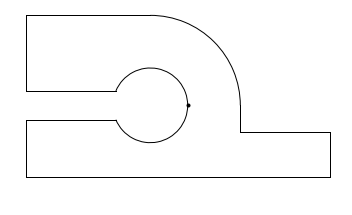

In [4]:
sketch = datalib.sketch_from_sequence(seq)
datalib.render_sketch(sketch);

We can also render the sketch with a hand-drawn appearance using matplotlib's xkcd drawing mode.

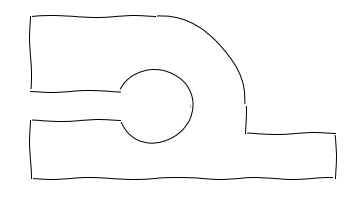

In [5]:
datalib.render_sketch(sketch, hand_drawn=True);

Next, we'll build a graph representation of the sketch and visualize it with pygraphviz.

In [6]:
G = datalib.pgvgraph_from_sequence(seq)
datalib.render_graph(G, '/tmp/my_graph.png')

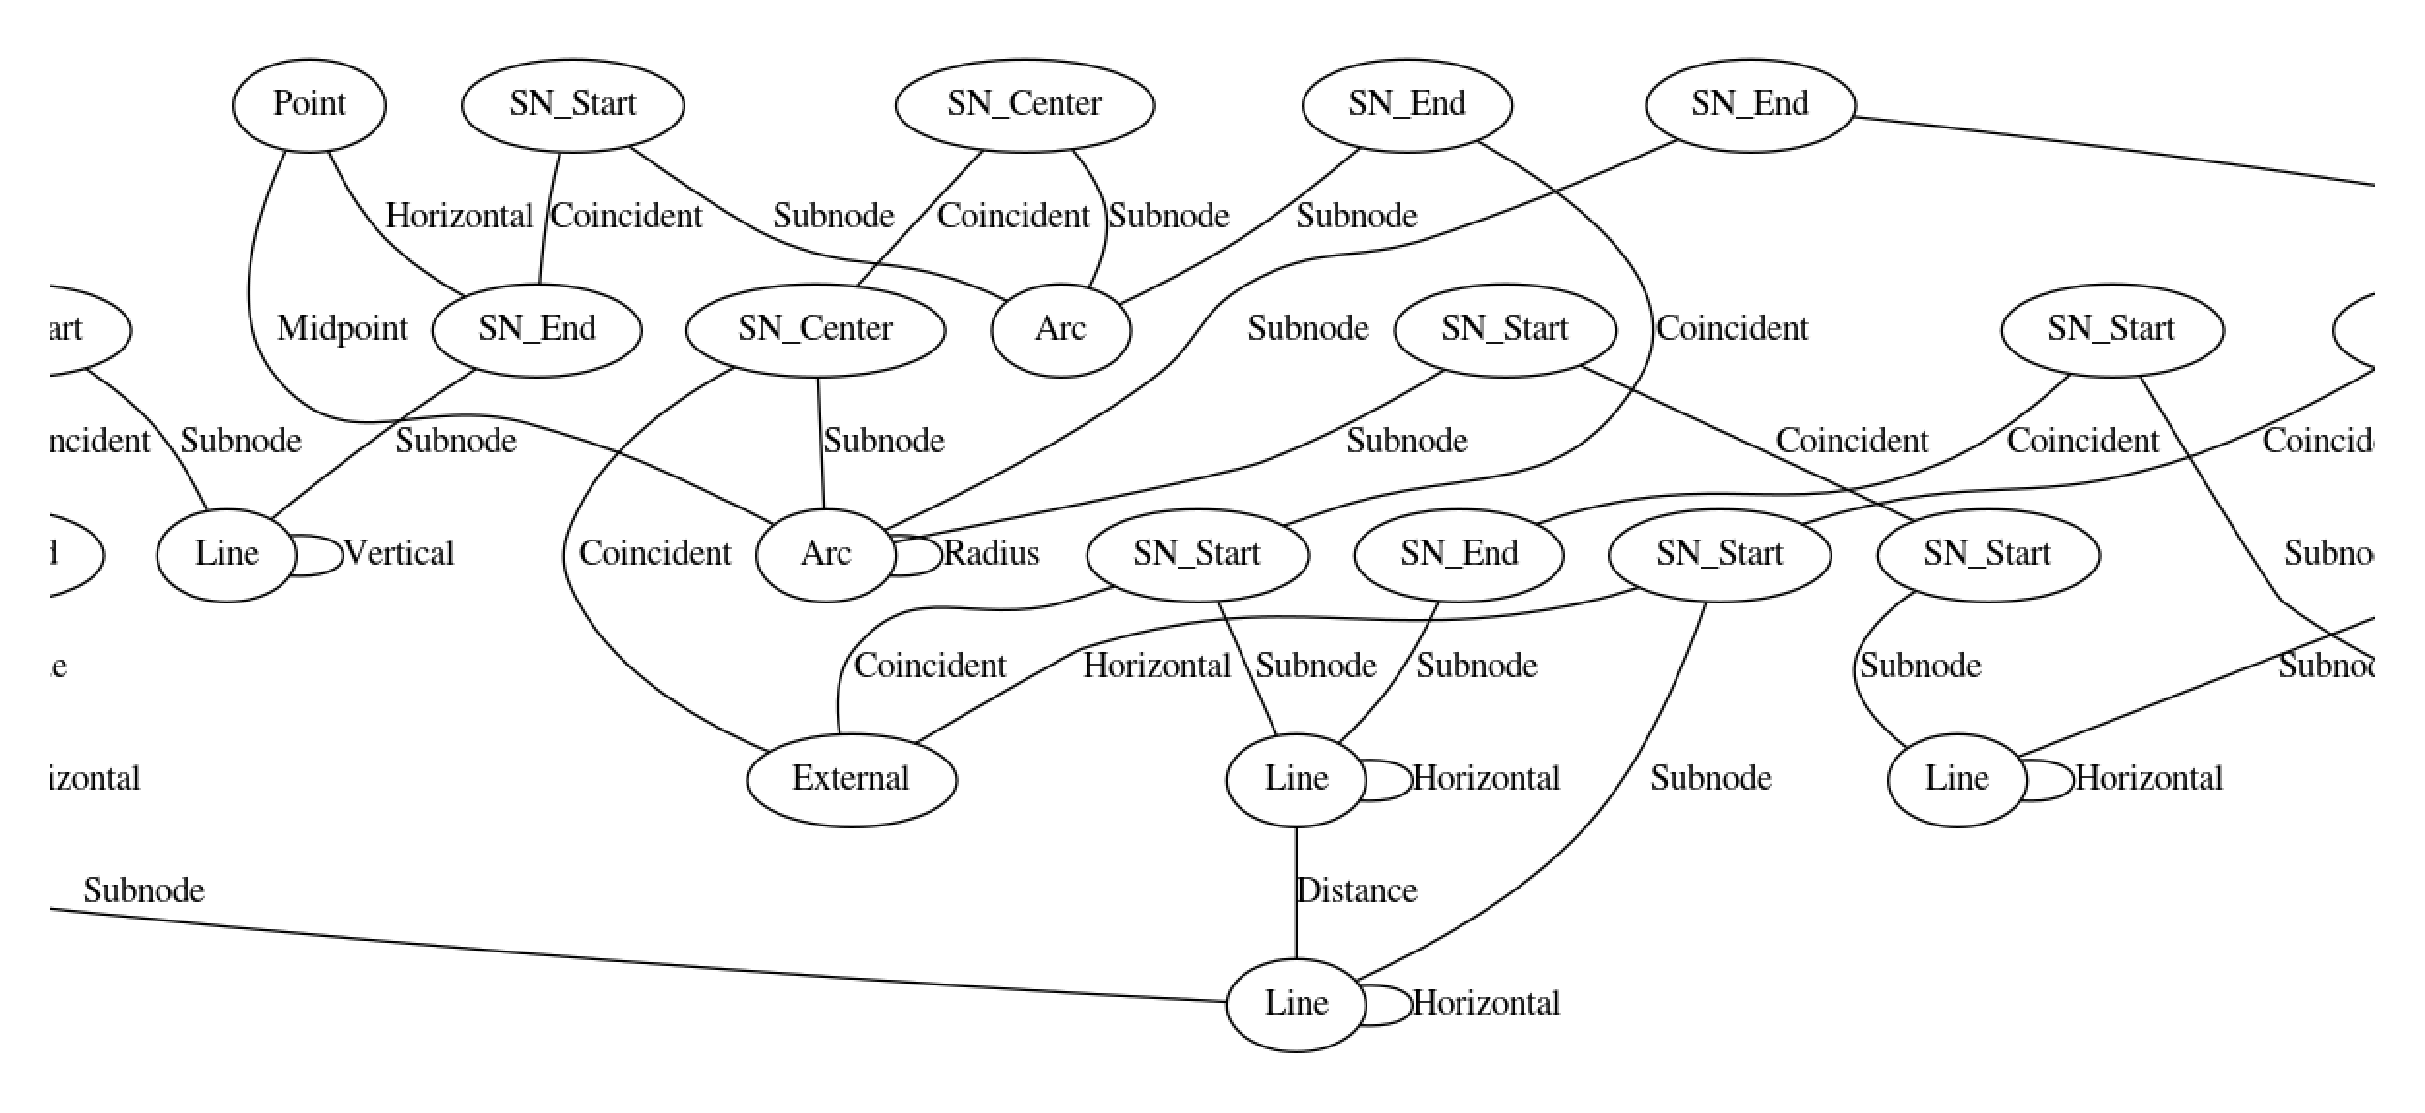

In [7]:
img = plt.imread('/tmp/my_graph.png')
fig = plt.figure(dpi=500)
plt.imshow(img[:, 500:1700])
plt.axis('off');

The full graph image for this example is large so we only display a portion of it above. Node labels that begin with `SN` are _subnodes_, specifying a point on some primitive (e.g., an endpoint of a line segment).

### Solving

We'll now take a look at how we can interact with Onshape's API in order to pass sketches to a geometric constraint solver. Various command line utilities for the API are defined in `sketchgraphs/onshape/call.py`.

Onshape developer credentials are required for this. Visit https://princetonlips.github.io/SketchGraphs/onshape_setup for directions. The default path for credentials is `sketchgraphs/onshape/creds/creds.json`.

We need to specify the URL of the Onshape document/PartStudio we'll be using. You should set the following `url` for your own document accordingly.

In [9]:
url = R'https://cad.onshape.com/documents/6f6d14f8facf0bba02184e88/w/66a5db71489c81f4893101ed/e/120c56983451157d26a7102d'

Let's test out Onshape's solver. We'll first make a copy of our sketch, remove its constraints, and manually add noise to the entity positions within Onshape's GUI.

In [10]:
no_constraint_sketch = deepcopy(sketch)
no_constraint_sketch.constraints.clear()
onshape_call.add_feature(url, no_constraint_sketch.to_dict(), 'No_Constraints_Sketch')

Before running the next code block, manually "mess up" the entities a bit in the GUI, i.e., drag the entities in order to leave the original constraints unsatisfied. The more drastic the change, the more difficult it will be for the solver to find a solution.

Now we retrieve the noisy sketch.

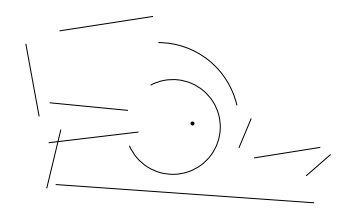

In [11]:
unsolved_sketch_info = onshape_call.get_info(url, 'No_Constraints_Sketch')
unsolved_sketch = datalib.Sketch.from_info(unsolved_sketch_info['geomEntities'])
datalib.render_sketch(unsolved_sketch);

Next, let's add the constraints back in and (attempt to) solve them.

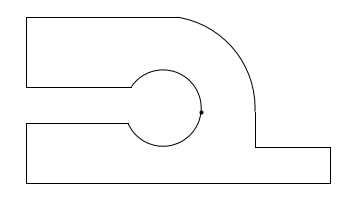

In [12]:
with_constraints_sketch = deepcopy(unsolved_sketch)
with_constraints_sketch.constraints = sketch.constraints
onshape_call.add_feature(url, with_constraints_sketch.to_dict(), 'With_Constraints_Sketch')
solved_sketch_info = onshape_call.get_info(url, 'With_Constraints_Sketch')
solved_sketch = datalib.Sketch.from_info(solved_sketch_info['geomEntities'])
datalib.render_sketch(solved_sketch);